## The Big Project begins!!

# "THE PRICE IS RIGHT" Capstone Project

This week - build a model that predicts how much something costs from a description, based on a scrape of Amazon data

# Order of play

DAY 1: Data Curation  
DAY 2: Data Pre-processing  
DAY 3: Evaluation, Baselines, Traditional ML  
DAY 4: Deep Learning and LLMs  
DAY 5: Fine-tuning a Frontier Model  

## DAY 1: Data Curation

Today we'll scrub our dataset and curate our data

The dataset is here:  
https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023

And the folder with all the product datasets is here:  
https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023/tree/main/raw/meta_categories

<table style="margin: 0; text-align: left;">
    <tr>
        <td style="width: 150px; height: 150px; vertical-align: middle;">
            <img src="../assets/business.jpg" width="150" height="150" style="display: block;" />
        </td>
        <td>
            <h2 style="color:#181;">Business value of Data Curation</h2>
            <span style="color:#181;">Data Curation can be considered the less glamorous work of a Data Scientist. I say that's nonsense!
            This is where the science happens - what could be more glamorous than that?! R&D with your
            dataset can often have a greater impact on performance than the fashionable 'hyper-parameter optimization' that we do later.
            So: prepare for Quality Time with Data Quality.</span>
        </td>
    </tr>
</table>

In [1]:
!pip install --upgrade datasets==3.6.0

In [2]:
# imports

import os
from dotenv import load_dotenv
from huggingface_hub import login
from datasets import load_dataset
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import random
from pricer.items import Item
from pricer.parser import parse
load_dotenv(override=True)

False

In [3]:
# Log in to HuggingFace - if you get a "Note" about Environment variable being set, ignore it
from google.colab import userdata


hf_token = userdata.get('HF_TOKEN')
login(hf_token, add_to_git_credential=True)

## Load our dataset

In the next cell, we load in the dataset from huggingface.

If this gives you an error like "trust_remote_code is no longer supported", then please run this command in a new cell: `!uv add --upgrade datasets==3.6.0` and then restart the Kernel, and try again.

In [4]:
dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_meta_Appliances", split="full", trust_remote_code=True)

README.md: 0.00B [00:00, ?B/s]

Amazon-Reviews-2023.py: 0.00B [00:00, ?B/s]

raw/meta_categories/meta_Appliances.json(…):   0%|          | 0.00/285M [00:00<?, ?B/s]

Generating full split: 0 examples [00:00, ? examples/s]

In [5]:
print(f"Number of Appliances: {len(dataset):,}")

Number of Appliances: 94,327


In [6]:
# Investigate a particular datapoint

dataset[6]


{'main_category': 'Appliances',
 'title': 'WD12X10327 Rack Roller and stud assembly Kit (4 Pack) by AMI PARTS Replaces AP4980629 PS3486910 1811003',
 'average_rating': 4.6,
 'rating_number': 323,
 'features': ['【PARTS NUMBER】The WD12X10327 dishwasher top rack wheels and stud assembly Kit （4 pcs）',
  '【SCOPE OF APPLICATION】The dishwasher works with most top name brands,If you are not sure if part is correct, ask us in Customer questions & answers section or visiting the AMI PARTS storefront.We’re happy to help ensure you select the correct part for your Rack Roller and stud',
  '【REPLACES PART】1811003, AP4980629, WD12X0330, WD12X0356, WD12X0357, WD12X0383, WD12X0385, WD12X10327, WD12X330, WD12X356, WD12X357, WD12X383, WD12X385',
  '【FIXES SYMPTOMS】Door won’t close | Not cleaning dishes properly | Noisy | Door latch failure',
  '【QUALITY WARRANTY】The replacement part is made from durable high quality material and well-tested by manufacturer.For any reason you’re not satisfied,you can ask

In [7]:

# What's the most expensive item?

max_price = 0
max_item = None

for datapoint in tqdm(dataset):
    try:
        price = float(datapoint["price"])
        if price > max_price:
            max_item = datapoint
            max_price = price
    except ValueError:
        pass

print(f"The most expensive item is {max_item['title']} and it costs {max_price:,.2f}")

  0%|          | 0/94327 [00:00<?, ?it/s]

The most expensive item is TurboChef BULLET Rapid Cook Electric Microwave Convection Oven and it costs 21,095.62


This is the closest I can find - looks like it's going at a bargain price!!

https://www.amazon.com/TurboChef-Electric-Countertop-Microwave-Convection/dp/B01D05U9NO/

In [8]:
# Load into Item objects if they have a price range $1-$1000 and enough details

items = [parse(datapoint, "Appliances") for datapoint in tqdm(dataset)]
items = [item for item in items if item is not None]
print(f"There are {len(items):,} items from {len(dataset):,} datapoints")

  0%|          | 0/94327 [00:00<?, ?it/s]

There are 35,307 items from 94,327 datapoints


In [9]:
items[0]

<WD12X10327 Rack Roller and stud assembly Kit (4 Pack) by AMI PARTS Replaces AP4980629 PS3486910 1811003 = $8.99>

In [10]:
print(items[0].full)

Rack Roller and stud assembly Kit (4 Pack) by AMI PARTS Replaces   1811003
['【PARTS NUMBER】The  dishwasher top rack wheels and stud assembly Kit （4 pcs）', '【SCOPE OF 】The dishwasher works with most top name brands,If you are not sure if part is correct, ask us in Customer questions & answers section or visiting the AMI PARTS storefront.We’re happy to help ensure you select the correct part for your Rack Roller and stud', '【 PART】, , , , , , , , , , , , ', '【FIXES SYMPTOMS】Door won’t close | Not cleaning dishes properly | Noisy | Door latch failure', '【QUALITY WARRANTY】The replacement part is made from durable high quality material and well-tested by manufacturer.For any reason you’re not satisfied,you can ask for a replacement or full refund']
{"Brand Name": "AMI PARTS", "Model Info": "", "Item Weight": "0.634 ounces", "Color": "White", "Material Type": "Plastic", "Date First Available": "July 14, 2019", "Brand": "AMI PARTS", "Material": "Plastic", "Model Name": " Rack Roller and stud 

In [11]:
prices = [item.price for item in items]
lengths = [len(item.full) for item in items]

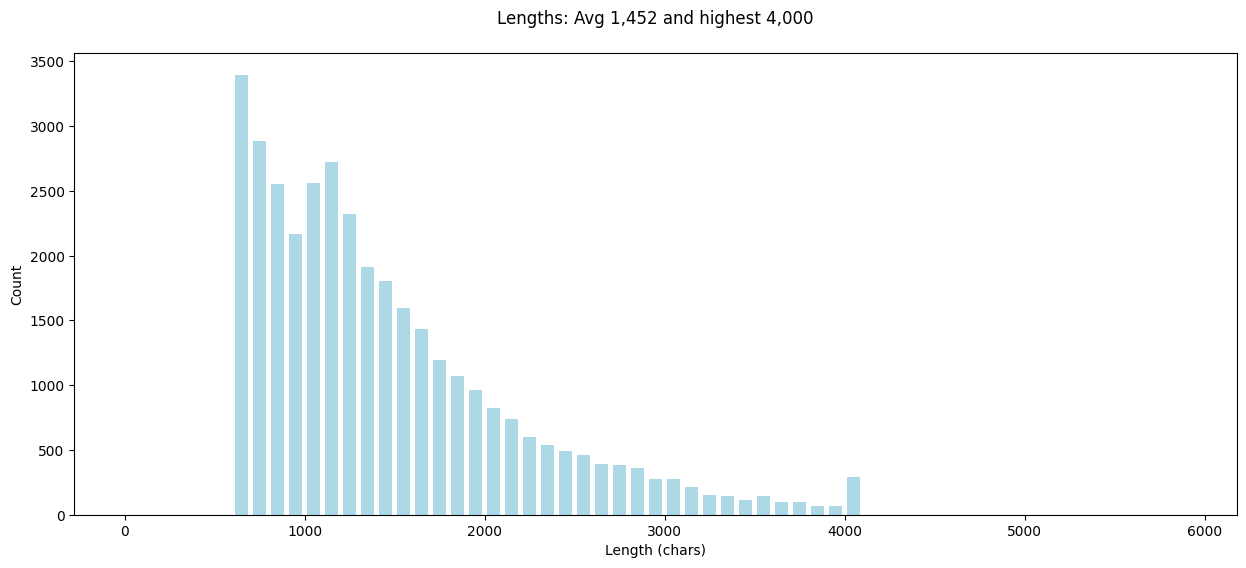

In [12]:
# Plot the distribution of lengths

plt.figure(figsize=(15, 6))
plt.title(f"Lengths: Avg {sum(lengths)/len(lengths):,.0f} and highest {max(lengths):,}\n")
plt.xlabel('Length (chars)')
plt.ylabel('Count')
plt.hist(lengths, rwidth=0.7, color="lightblue", bins=range(0, 6000, 100))
plt.show()

In [13]:
max_length = max(lengths)
max_length_item = items[lengths.index(max_length)]
print(max_length_item.full)


Polyester Dryer Vent Filters Replacement Part by Beaquicy Replacement for Better vent Indoor Dryer Vent Packs of 12
['✅【 AIR 】--- The polyester filters provide optimal air conditioning for your dryer and keep it away from polluted air. Because these parts will rate to trap fine lint and dust particles, protect your home from unwanted bacteria and other unfriendly dust particles and can be vacuumed clean or replaced when fully loaded with lint. so that the air in your room is cleaner than ever. While protecting your indoor quality, clothes can dry faster. It helps improve the indoor air quality.', '✅【HIGH-GRADE 】--- The package includes 12 x replacement polyester filters for bettervent.They are well-made from durable and high-grade polyester which can traps fine lint and dust particles, optimize the cleaning process and prolong lifetime. Each filter protects up to 5 dryer loads! For best results insert blue side facing towards dryer vent.', '✅【WIDE 】--- These polyester filters are desig

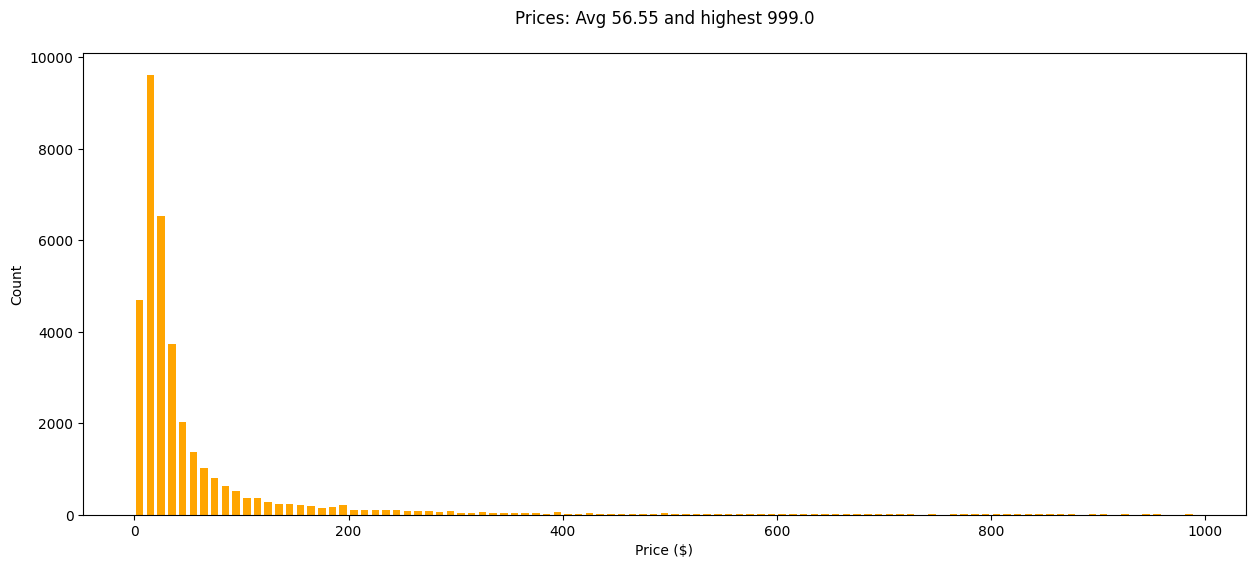

In [14]:
# Plot the distribution of prices
plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.2f} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="orange", bins=range(0, 1000, 10))
plt.show()

In [15]:
print(items[3].full)

MLGB Stainless Steel Brushed Pattern Dishwasher Magnet Cover Panel Decal Home Appliance Art, Stainless Steel Fridge Door Cover Decals Magnetic, Black, Mobile Magnetic 23" x 26"
['Stainless Steel Brushed Pattern Magnetic Dishwasher Panel Covers allow you to easily transform your kitchen as the seasons change. You can instantly get rid of outdated and/or mismatched appliances, will give your kitchen a refreshing look.', ':', 'Vinyl + rubber magnet', 'Occasion:', 'Magnet Dishwasher Cover Decor dishwasher covers and any metal device surface with magnetism.', '【Kitchen Dishwasher Covers SIZE】S - 23 W x 17 H inches; 58.5 W x 43 H cm;L - 23 W x 26 H inches; 58.5 W x 66 H cm;', 'Attention:', 'Just ensure that your dishwasher is magnetic before ordering the dishwasher cover magnet', 'Due to the inconsistent calibration of the monitor, the colors on the computer monitor may be slightly different.', 'Quality service:', 'If you have any questions or questions, please feel free to contact us and we

In [16]:
from pricer.loaders import ItemLoader
loader = ItemLoader("Appliances")
items = loader.load()


Loading dataset Appliances


100%|██████████| 95/95 [00:06<00:00, 14.59it/s]


Completed Appliances with 35,307 datapoints in 0.2 mins


In [17]:

dataset_names = [
    "Automotive",
    "Electronics",
    "Office_Products",
    "Tools_and_Home_Improvement",
    "Cell_Phones_and_Accessories",
    "Toys_and_Games",
    "Appliances",
    "Musical_Instruments",
]

In [18]:
items = []
for dataset_name in dataset_names:
    loader = ItemLoader(dataset_name)
    items.extend(loader.load())

Loading dataset Automotive


raw/meta_categories/meta_Automotive.json(…):   0%|          | 0.00/5.35G [00:00<?, ?B/s]

Generating full split: 0 examples [00:00, ? examples/s]

100%|██████████| 2004/2004 [02:50<00:00, 11.75it/s]


Completed Automotive with 974,469 datapoints in 8.1 mins
Loading dataset Electronics


raw/meta_categories/meta_Electronics.jso(…):   0%|          | 0.00/5.25G [00:00<?, ?B/s]

Generating full split:   0%|          | 0/1610012 [00:00<?, ? examples/s]

100%|██████████| 1611/1611 [01:58<00:00, 13.57it/s]


Completed Electronics with 464,024 datapoints in 6.8 mins
Loading dataset Office_Products


raw/meta_categories/meta_Office_Products(…):   0%|          | 0.00/2.15G [00:00<?, ?B/s]

Generating full split: 0 examples [00:00, ? examples/s]

100%|██████████| 711/711 [00:46<00:00, 15.15it/s]


Completed Office_Products with 248,767 datapoints in 2.8 mins
Loading dataset Tools_and_Home_Improvement


raw/meta_categories/meta_Tools_and_Home_(…):   0%|          | 0.00/4.85G [00:00<?, ?B/s]

Generating full split: 0 examples [00:00, ? examples/s]

100%|██████████| 1474/1474 [02:01<00:00, 12.14it/s]


Completed Tools_and_Home_Improvement with 552,147 datapoints in 6.3 mins
Loading dataset Cell_Phones_and_Accessories


raw/meta_categories/meta_Cell_Phones_and(…):   0%|          | 0.00/4.02G [00:00<?, ?B/s]

Generating full split:   0%|          | 0/1288490 [00:00<?, ? examples/s]

100%|██████████| 1289/1289 [01:23<00:00, 15.45it/s]


Completed Cell_Phones_and_Accessories with 242,351 datapoints in 5.2 mins
Loading dataset Toys_and_Games


raw/meta_categories/meta_Toys_and_Games.(…):   0%|          | 0.00/2.64G [00:00<?, ?B/s]

Generating full split:   0%|          | 0/890874 [00:00<?, ? examples/s]

100%|██████████| 891/891 [01:03<00:00, 14.09it/s]


Completed Toys_and_Games with 347,657 datapoints in 3.6 mins
Loading dataset Appliances


100%|██████████| 95/95 [00:07<00:00, 12.18it/s]


Completed Appliances with 35,307 datapoints in 0.2 mins
Loading dataset Musical_Instruments


raw/meta_categories/meta_Musical_Instrum(…):   0%|          | 0.00/632M [00:00<?, ?B/s]

Generating full split:   0%|          | 0/213593 [00:00<?, ? examples/s]

100%|██████████| 214/214 [00:12<00:00, 17.02it/s]


Completed Musical_Instruments with 68,855 datapoints in 0.9 mins


In [19]:
print(f"A grand total of {len(items):,} items")

A grand total of 2,933,577 items


In [20]:
items[1000]

<Coolant Temperature Sensor Compatible with Volvo V70 850 S70 960 C70 S90 V90 1997-1998 = $26.7>

In [21]:
random.seed(42)
random.shuffle(items)

seen = set()
items = [x for x in tqdm(items) if not (x.title in seen or seen.add(x.title))]

seen = set()
items = [x for x in tqdm(items) if not (x.full in seen or seen.add(x.full))]

del seen
print(f"After deduplication, we have {len(items):,} items")

  0%|          | 0/2933577 [00:00<?, ?it/s]

  0%|          | 0/2889429 [00:00<?, ?it/s]

After deduplication, we have 2,887,890 items


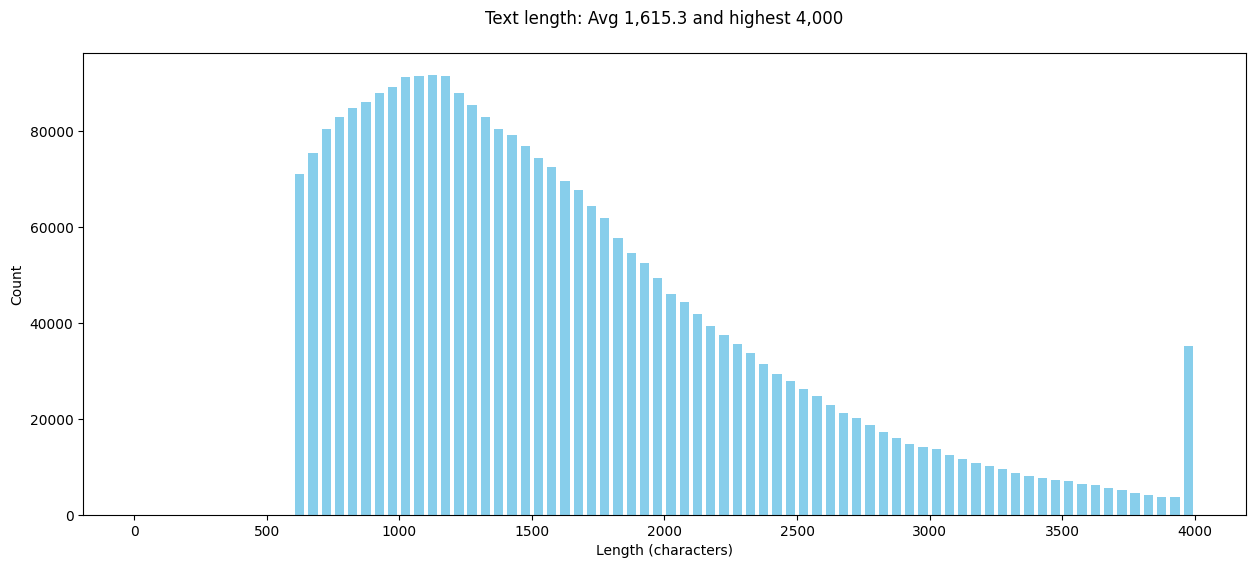

In [22]:
lengths = [len(item.full) for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Text length: Avg {sum(lengths)/len(lengths):,.1f} and highest {max(lengths):,}\n")
plt.xlabel('Length (characters)')
plt.ylabel('Count')
plt.hist(lengths, rwidth=0.7, color="skyblue", bins=range(0, 4050, 50))
plt.show()

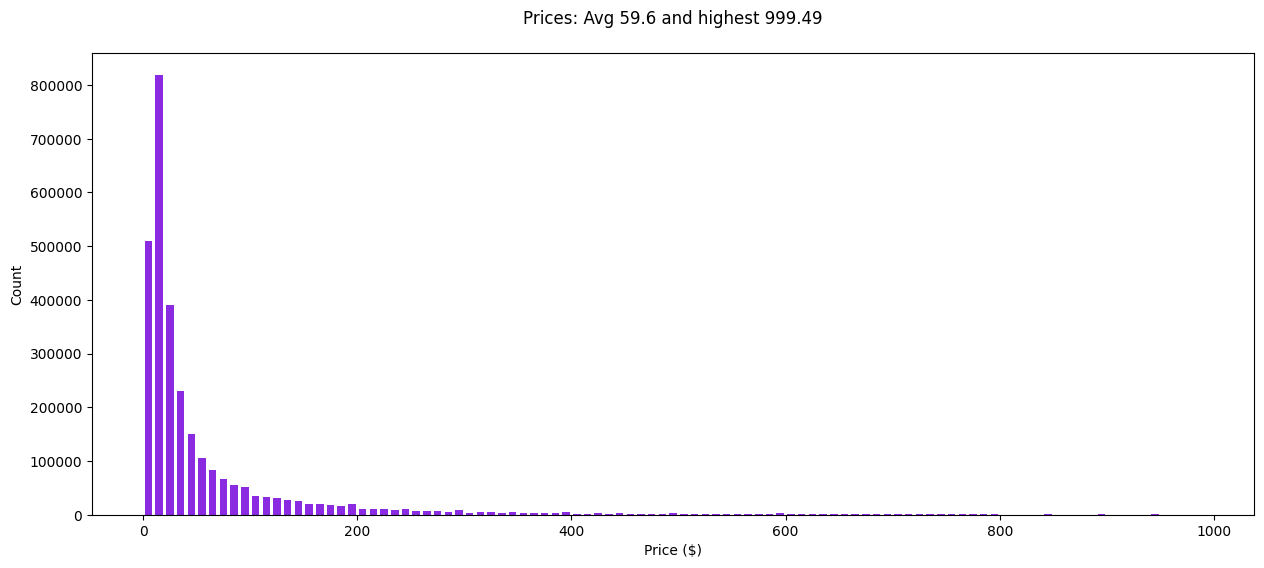

In [23]:
# Plot the distribution of prices

prices = [item.price for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.1f} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="blueviolet", bins=range(0, 1000, 10))
plt.show()

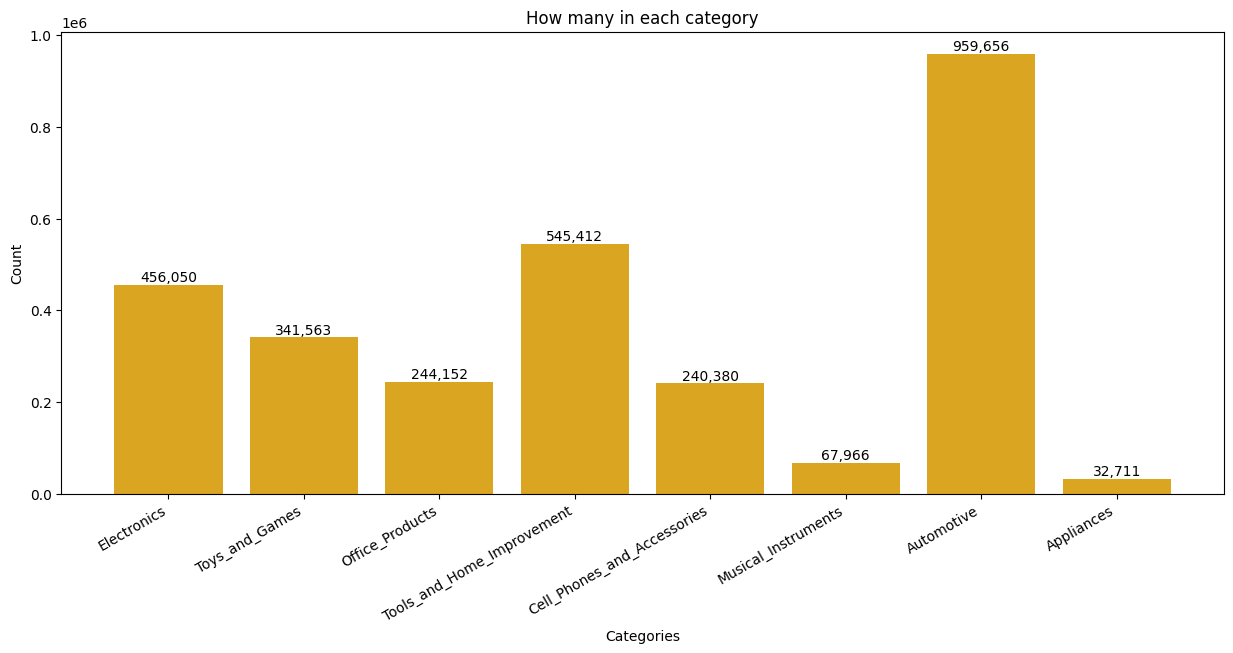

In [24]:
from collections import Counter
category_counts = Counter([item.category for item in items])

categories = category_counts.keys()
counts = [category_counts[category] for category in categories]

plt.figure(figsize=(15, 6))
plt.bar(categories, counts, color="goldenrod")
plt.title('How many in each category')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.xticks(rotation=30, ha='right')

for i, v in enumerate(counts):
    plt.text(i, v, f"{v:,}", ha='center', va='bottom')

plt.show()

In [25]:
np.random.seed(42)

SIZE = 820_000

prices = np.array([it.price for it in items], dtype=float)
categories = np.array([it.category for it in items])
p = (prices - prices.min()) / (prices.max() - prices.min() + 1e-9)

w = p**2
w[categories == "Tools_and_Home_Improvement"] *= 0.5
w[categories == "Automotive"] *= 0.05

w = w / w.sum()
idx = np.random.choice(len(items), size=SIZE, replace=False, p=w)
sample = [items[i] for i in idx]


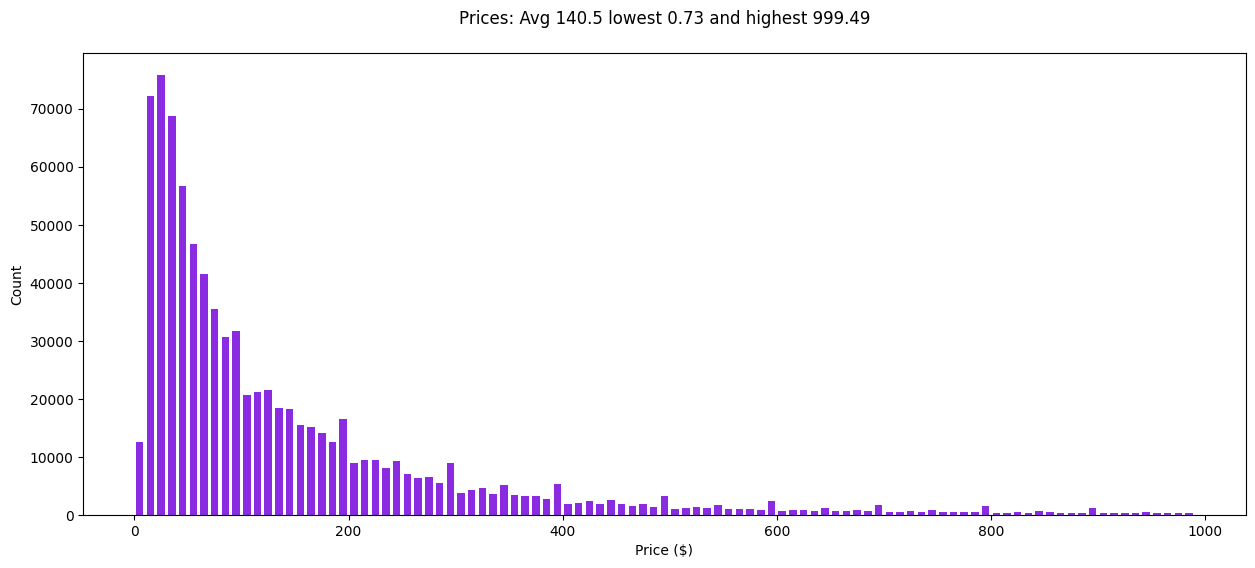

In [26]:
prices = [item.price for item in sample]
plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.1f} lowest {min(prices):,} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="blueviolet", bins=range(0, 1000, 10))
plt.show()

In [27]:
# Just for good measure, let's shuffle the sample again for the final dataset

random.seed(42)
random.shuffle(sample)


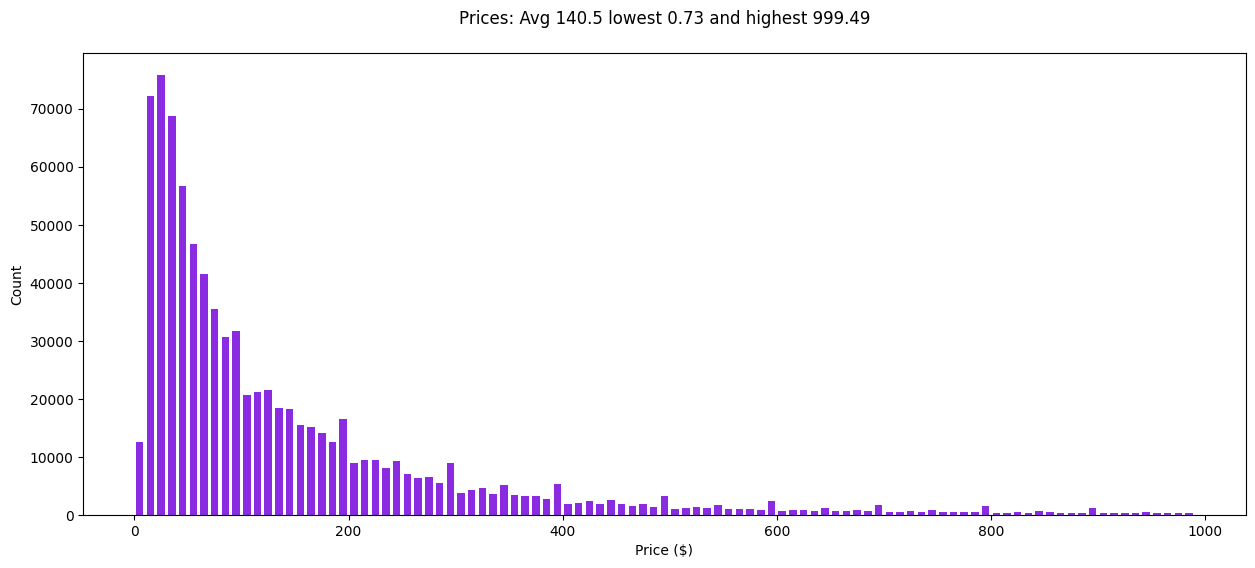

In [28]:
prices = [item.price for item in sample]
plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.1f} lowest {min(prices):,} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="blueviolet", bins=range(0, 1000, 10))
plt.show()

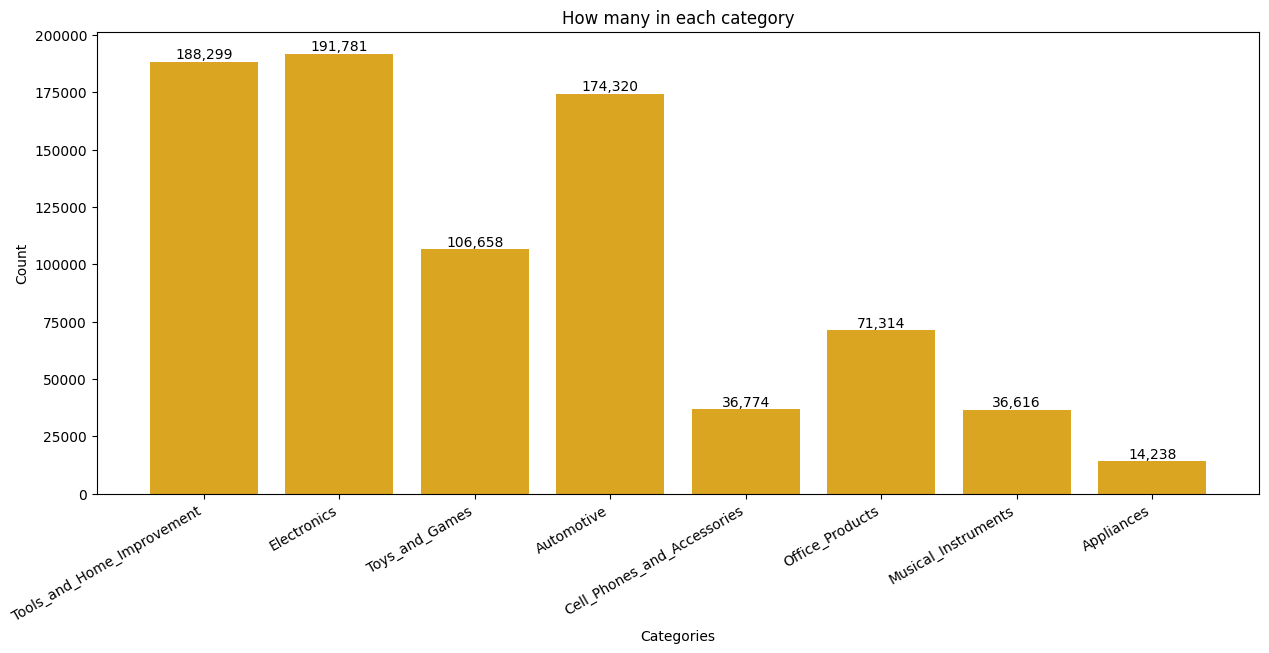

In [29]:
from collections import Counter
category_counts = Counter([item.category for item in sample])

categories = category_counts.keys()
counts = [category_counts[category] for category in categories]

# Bar chart by category
plt.figure(figsize=(15, 6))
plt.bar(categories, counts, color="goldenrod")
plt.title('How many in each category')
plt.xlabel('Categories')
plt.ylabel('Count')

plt.xticks(rotation=30, ha='right')

# Add value labels on top of each bar
for i, v in enumerate(counts):
    plt.text(i, v, f"{v:,}", ha='center', va='bottom')

# Display the chart
plt.show()

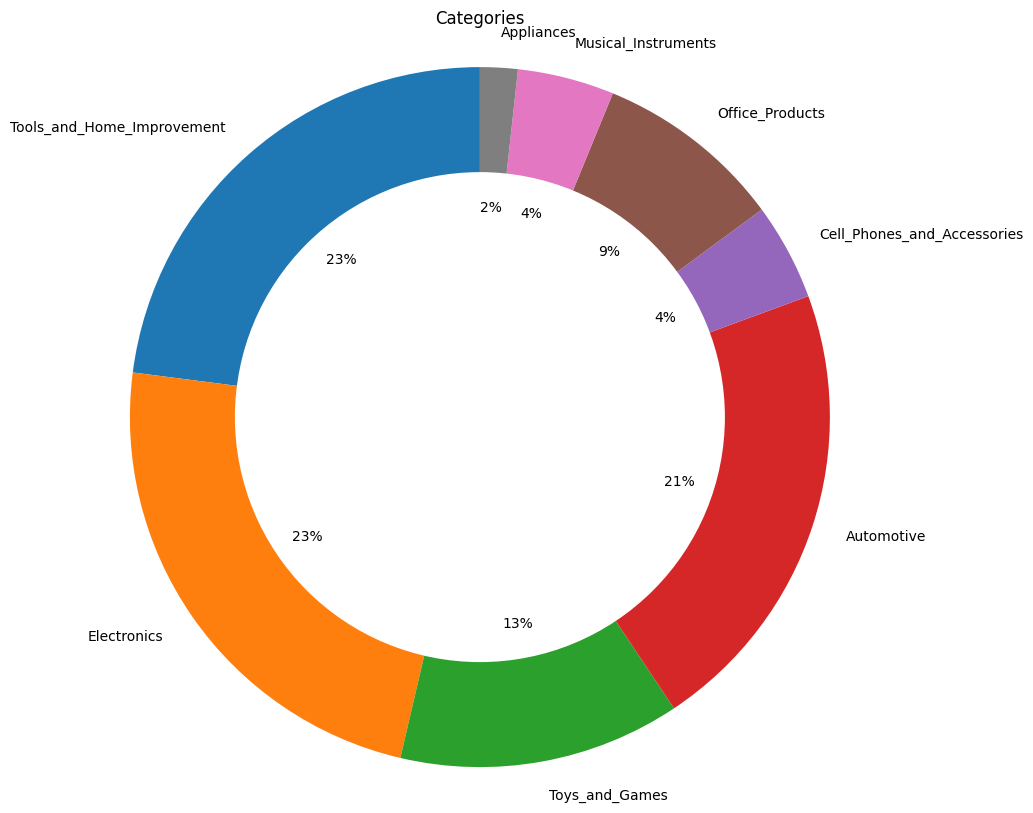

In [30]:
# Automotive still in the lead, but improved somewhat
# For another perspective, let's look at a pie

plt.figure(figsize=(12, 10))
plt.pie(counts, labels=categories, autopct='%1.0f%%', startangle=90)

# Add a circle at the center to create a donut chart (optional)
centre_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Categories')

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')

plt.show()

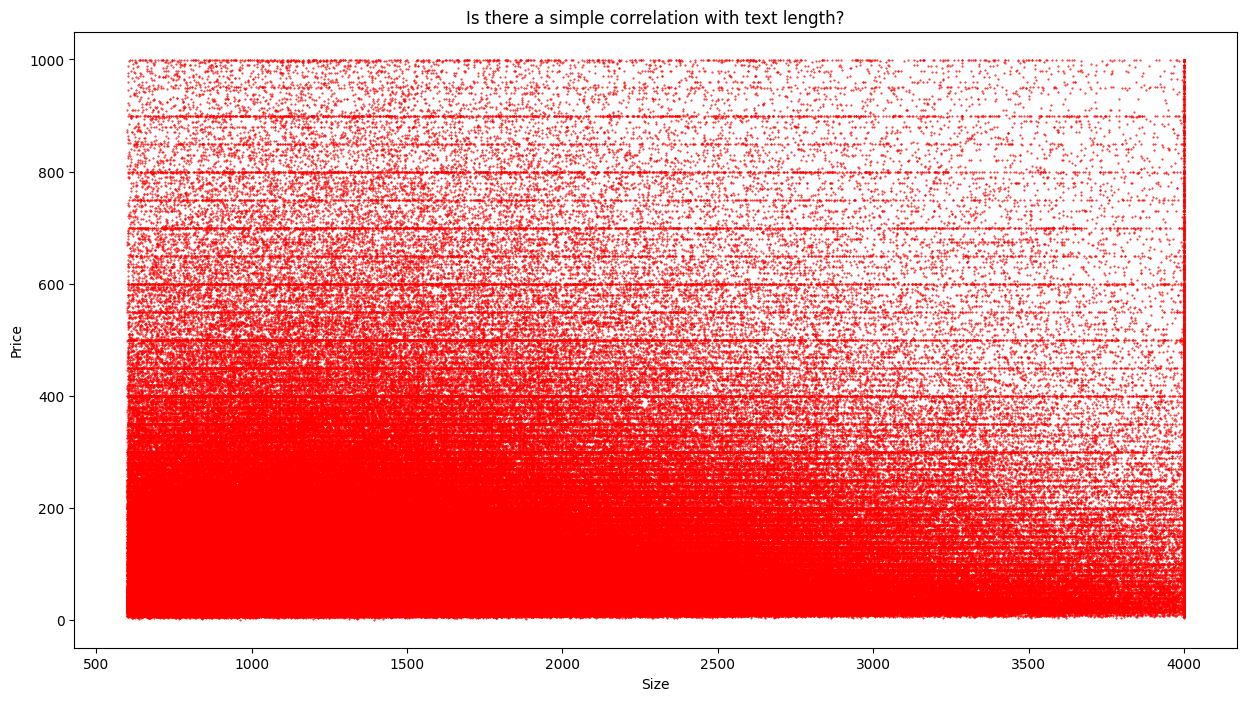

In [31]:
# How does the price vary with the character count?

sizes = [len(item.full) for item in sample]
prices = [item.price for item in sample]

# Create the scatter plot
plt.figure(figsize=(15, 8))
plt.scatter(sizes, prices, s=0.2, color="red")

# Add labels and title
plt.xlabel('Size')
plt.ylabel('Price')
plt.title('Is there a simple correlation with text length?')

# Display the plot
plt.show()

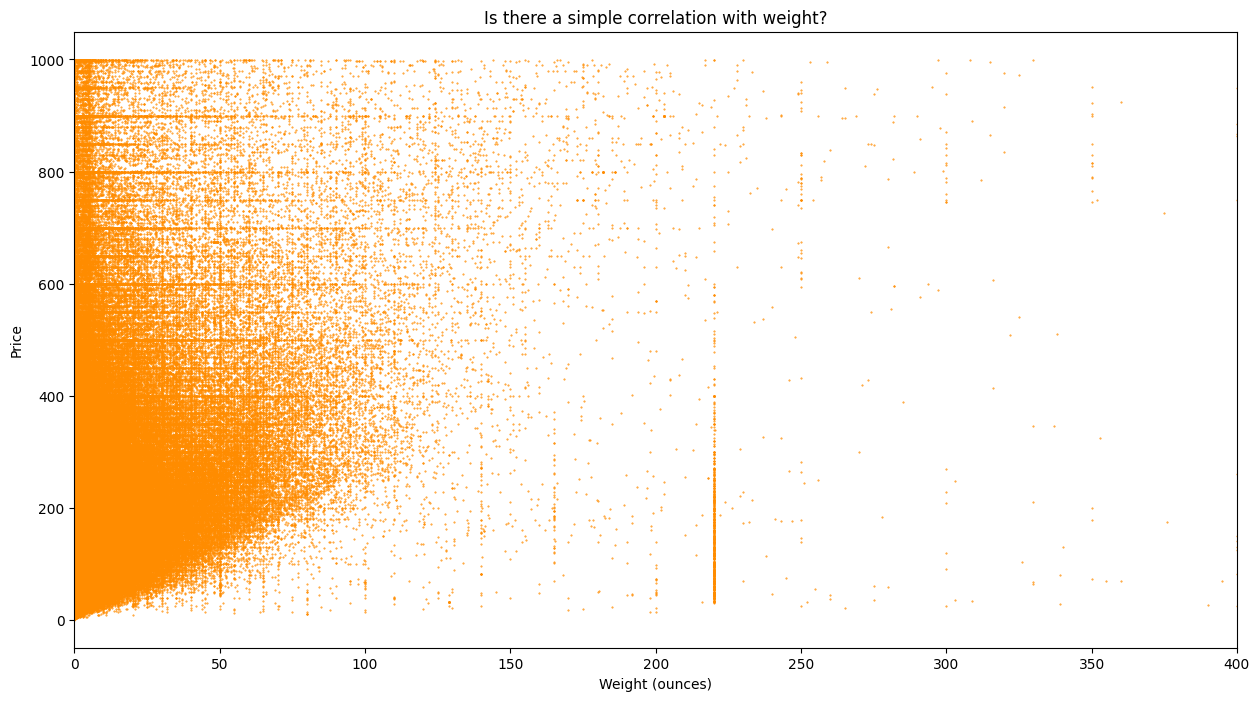

In [32]:
# How does the price vary with the weight?

ounces = [item.weight for item in sample]
prices = [item.price for item in sample]

# Create the scatter plot
plt.figure(figsize=(15, 8))
plt.scatter(ounces, prices, s=0.2, color="darkorange")

# Add labels and title
plt.xlabel('Weight (ounces)')
plt.ylabel('Price')
plt.xlim(0, 400)
plt.title('Is there a simple correlation with weight?')

# Display the plot
plt.show()

## Now push this dataset to the HuggingFace Hub

Replace the username with your HF username if you've crafted your own dataset

Or, ignore this cell and you can load my dataset tomorrow!

In [33]:
# username = "ed-donner"
# full = f"{username}/items_raw_full"
# lite = f"{username}/items_raw_lite"

# train = sample[:800_000]
# val = sample[800_000:810_000]
# test = sample[810_000:]

# Item.push_to_hub(full, train, val, test)

# train_lite = train[:20_000]
# val_lite = val[:1_000]
# test_lite = test[:1_000]

# Item.push_to_hub(lite, train_lite, val_lite, test_lite)

## Sidenote

If you like the variety of colors that matplotlib can use in its charts, you should bookmark this:

https://matplotlib.org/stable/gallery/color/named_colors.html
